In [56]:
import pandas as pd
import duckdb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import joblib
import pickle

# Funções Auxiliares

In [57]:
def conferir_missing(df):
    missing_found = False
    for col in df.columns:
        # Conta NaNs
        n_null = df[col].isnull().sum()
        # Conta 'unknown' apenas em colunas do tipo object (strings)
        n_unknown = 0
        if df[col].dtype == 'object':
            n_unknown = (df[col] == 'unknown').sum()

        total_missing = n_null + n_unknown

        if total_missing > 0:
            missing_found = True
            perc = round(100 * total_missing / len(df), 2)
            print(f"{col}: {total_missing} missing ({perc}%)")

    if not missing_found:
        print('Não há missing no banco de dados')


def categorize_corr(val):
    if abs(val) >= 0.7:
        return 'Alto'
    elif abs(val) >= 0.4:
        return 'Moderado'
    elif abs(val) >= 0.1:
        return 'Baixo'
    else:
        return 'Nenhum'


# Ingestão e Armazenamento

In [58]:
df = pd.read_csv('/content/drive/MyDrive/Data_Engineer_JR_TOTVS/bank.xls', delimiter=',')

In [59]:
con = duckdb.connect('bank.duckdb')
con.register('bank', df)

In [60]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [61]:
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


# Exploração de Dados

### Quantas linhas e colunas o dataset possui?


In [62]:
print(len(df))
print(len(df.columns))

11162
17


In [63]:
n_linhas = con.execute("SELECT COUNT(*) FROM bank").fetchone()[0]
n_colunas = con.execute("""
    SELECT COUNT(*)
    FROM information_schema.columns
    WHERE table_name = 'bank'
""").fetchone()[0]


print(f"O dataset possui {n_linhas} linhas e {n_colunas} colunas.")

O dataset possui 11162 linhas e 17 colunas.


### Existem valores nulos? Em quais colunas e quantos?

In [64]:
conferir_missing(df)

job: 70 missing (0.63%)
education: 497 missing (4.45%)
contact: 2346 missing (21.02%)
poutcome: 8326 missing (74.59%)


In [65]:
cols = df.select_dtypes(include='object').columns.to_list()
query = "SELECT\n"
query += ",\n".join([f"COUNT(*) FILTER (WHERE \"{col}\" = 'unknown') AS unknown_{col}" for col in cols])
query += "\nFROM bank;"
result = con.execute(query).fetchdf()
print(result.T)


                      0
unknown_job          70
unknown_marital       0
unknown_education   497
unknown_default       0
unknown_housing       0
unknown_loan          0
unknown_contact    2346
unknown_month         0
unknown_poutcome   8326
unknown_deposit       0


### Qual a correlação entre variáveis numéricas??

In [66]:
numerical_cols = df.select_dtypes(include='number').columns.to_list()
print("Colunas numéricas:", numerical_cols)

Colunas numéricas: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [67]:
corr_matrix = pd.DataFrame(np.eye(len(numerical_cols)), columns=numerical_cols, index=numerical_cols)

results = []

for i in range(len(numerical_cols)):
    for j in range(i+1, len(numerical_cols)):
        col1 = numerical_cols[i]
        col2 = numerical_cols[j]

        query = f"SELECT CORR({col1}, {col2}) FROM bank"
        corr_value = con.execute(query).fetchone()[0]

        results.append((col1, col2, corr_value))

for col1, col2, corr in results:
    corr_matrix.loc[col1, col2] = corr
    corr_matrix.loc[col2, col1] = corr

print(corr_matrix)

               age   balance       day  duration  campaign     pdays  previous
age       1.000000  0.112300 -0.000762  0.000189 -0.005278  0.002774  0.020169
balance   0.112300  1.000000  0.010467  0.022436 -0.013894  0.017411  0.030805
day      -0.000762  0.010467  1.000000 -0.018511  0.137007 -0.077232 -0.058981
duration  0.000189  0.022436 -0.018511  1.000000 -0.041557 -0.027392 -0.026716
campaign -0.005278 -0.013894  0.137007 -0.041557  1.000000 -0.102726 -0.049699
pdays     0.002774  0.017411 -0.077232 -0.027392 -0.102726  1.000000  0.507272
previous  0.020169  0.030805 -0.058981 -0.026716 -0.049699  0.507272  1.000000


/tmp/ipython-input-68-1319401606.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_labels = corr_matrix.applymap(categorize_corr)


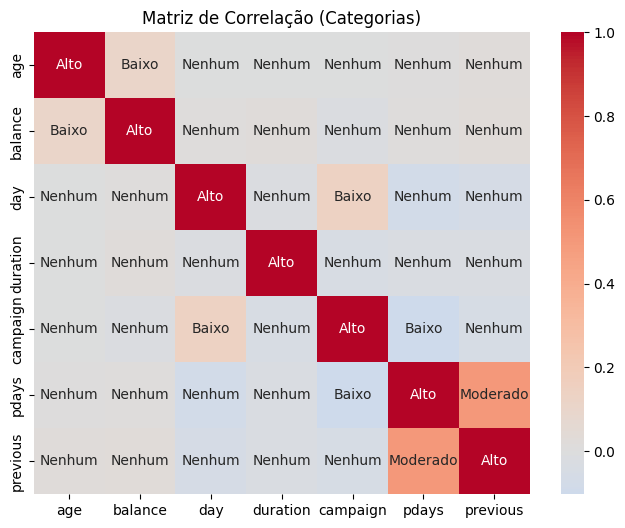

In [68]:
annot_labels = corr_matrix.applymap(categorize_corr)


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=annot_labels, fmt='', cmap='coolwarm', center=0)
plt.title('Matriz de Correlação (Categorias)')
plt.show()

# Pré-processamento


### Trate valores nulos adequadamente.

In [69]:
df['job'] = df['job'].replace('unknown', df['job'].mode()[0]) # porque a a proporção é baixa: 0.63% mas, também posso apagar
df['education'] = df['education'].replace('unknown', df['education'].mode()[0]) # porque a a proporção é baixa: 4.45%
df['poutcome'] = df['poutcome'].replace('unknown', 'sem_contato_anterior') # como a proporção é alta, 74% vale a pena manter esses valores

### Converta variáveis categóricas para numéricas (One-Hot Encoding ou Ordinal).

In [70]:
for col in ['default', 'housing', 'loan', 'deposit']:
    print(f"Valores únicos em {col}: {df[col].unique()}")


Valores únicos em default: ['no' 'yes']
Valores únicos em housing: ['yes' 'no']
Valores únicos em loan: ['no' 'yes']
Valores únicos em deposit: ['yes' 'no']


In [71]:
binarias = ['deposit', 'default', 'housing', 'loan']

for col in binarias:
    df[col] = df[col].map({'yes': 1, 'no': 0})

In [72]:
df["deposit"]

,deposit
0,1
1,1
2,1
3,1
4,1
...,...
11157,0
11158,0
11159,0
11160,0


In [73]:
categ_nomes = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
df_encoded = pd.get_dummies(df, columns=categ_nomes, drop_first=True)

In [74]:
df_encoded.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_sem_contato_anterior,poutcome_success
0,59,0,2343,1,0,5,1042,1,-1,0,...,False,False,False,True,False,False,False,False,True,False
1,56,0,45,0,0,5,1467,1,-1,0,...,False,False,False,True,False,False,False,False,True,False
2,41,0,1270,1,0,5,1389,1,-1,0,...,False,False,False,True,False,False,False,False,True,False
3,55,0,2476,1,0,5,579,1,-1,0,...,False,False,False,True,False,False,False,False,True,False
4,54,0,184,0,0,5,673,2,-1,0,...,False,False,False,True,False,False,False,False,True,False


In [75]:
conferir_missing(df_encoded)

Não há missing no banco de dados


### Divisão do treino e teste

In [76]:
# X = df_encoded.drop('deposit', axis=1)
# y = df_encoded['deposit']

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42, stratify=y
# )

In [77]:
X = df.drop('deposit', axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [78]:
y_train.mean(),y_test.mean() #Proporcionalmente, a qt de 0 e 1 está equilibrada

(np.float64(0.47384925523574867), np.float64(0.4738020600089566))

In [79]:
#Identificando o tipo de cada variável com list comprehension
vars_cat = [col for col in list(X_train.columns) if X_train[col].dtypes == object]
vars_int = [col for col in list(X_train.columns) if ((X_train[col].dtypes == int) and (X_train[col].unique().sum()>2))]
vars_dummy = [col for col in list(X_train.columns) if ((X_train[col].dtypes == int or X_train[col].dtypes == bool) and (X_train[col].unique().sum()<=2))]
vars_float = [col for col in list(X_train.columns) if X_train[col].dtypes == float]

In [80]:
vars_dummy

['default', 'housing', 'loan']

In [81]:
vars_cat

['job', 'marital', 'education', 'contact', 'month', 'poutcome']

In [82]:
len(X_train.columns), (len(vars_cat)+len(vars_int)+len(vars_float)+len(vars_dummy)) #Volume Bateu

(16, 16)

In [83]:
encoder = OneHotEncoder(handle_unknown='ignore').fit(X_train[vars_cat])

In [84]:
X_train.tail() #exibinto que X_train nao possui ainda as variáveis

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
3751,34,unemployed,single,tertiary,0,1974,0,0,cellular,22,jul,355,1,342,3,success
9695,42,blue-collar,married,secondary,0,3,1,0,cellular,12,may,118,1,-1,0,sem_contato_anterior
3579,55,admin.,married,secondary,0,8304,0,0,cellular,1,jun,201,1,-1,0,sem_contato_anterior
3386,53,admin.,married,secondary,0,459,0,0,cellular,5,apr,558,1,-1,0,sem_contato_anterior
9743,41,blue-collar,married,secondary,0,393,1,1,cellular,10,jul,122,1,-1,0,sem_contato_anterior


In [85]:
#Mostrando output do encoder
encoder.transform(X_train[vars_cat]).toarray() #Precisa incluir o toarray() para gerar a matriz do numpy

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [86]:
#Gera o rotulo das colunas
list(encoder.get_feature_names_out())

['job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'poutcome_failure',
 'poutcome_other',
 'poutcome_sem_contato_anterior',
 'poutcome_success']

In [87]:
#Uso os rotulos das colunas + matriz do numpy para criar as colunas novas no pandas Df
X_train[list(encoder.get_feature_names_out())] = encoder.transform(X_train[vars_cat]).toarray()
X_train.tail()

# Remove as colunas categóricas originais
X_train = X_train.drop(columns=vars_cat)

In [88]:
#Uso os rotulos das colunas + matriz do numpy para criar as colunas novas no pandas Df
X_test[list(encoder.get_feature_names_out())] = encoder.transform(X_test[vars_cat]).toarray()
X_test.tail()

X_test = X_test.drop(columns=vars_cat)

In [89]:
#Salvando o objeto que padroniza os dados com o pickle
filename = 'onehotencoding_variaveis_categoricas.sav'
pickle.dump(encoder, open(filename, 'wb'))

In [90]:
vars_outliers = []

for col in vars_int+vars_float:
  Q1, Q3 = X_train[col].describe()['25%'],X_train[col].describe()['75%']
  IQR = Q3-Q1 #Intervalo Interquartil

  if (X_train[col].describe()['min'] < (Q1 - (1.5*IQR))) or (X_train[col].describe()['max'] > (Q3 + (1.5*IQR))):
    vars_outliers.append(col)

In [91]:
len(vars_outliers)

6

In [92]:
vars_outliers = []

for col in vars_int+vars_float:
  Q1, Q3 = X_train[col].describe()['25%'],X_train[col].describe()['75%']
  IQR = Q3-Q1 #Intervalo Interquartil

  if ((X_train[col].describe()['min'] < (Q1 - (1.5*IQR))) or (X_train[col].describe()['max'] > (Q3 + (1.5*IQR)))):
    if len(X_train.loc[(X_train[col] < (Q1 - (1.5*IQR)))]) < int(len(X_train)*0.01): #Se for menor que 1% da base,
      X_train.loc[(X_train[col] < (Q1 - (1.5*IQR))), col] = int(Q1 - (1.5*IQR)) #Substituo pelo Limite Inferior
    if (X_train[col].describe()['max'] > (Q3 + (1.5*IQR))) < int(len(X_train)*0.01):
      X_train.loc[(X_train[col] > (Q3 + (1.5*IQR))), col] = int(Q3 + (1.5*IQR)) #Substituo pelo Limite Superior
    if (X_train[col].describe()['min'] < (Q1 - (1.5*IQR))) or (X_train[col].describe()['max'] > (Q3 + (1.5*IQR))): #Se nao der certo os tratamentos acima,
      vars_outliers.append(col)

len(vars_outliers)

0

### Normalize ou padronize colunas numéricas, se necessário.

In [93]:
vars_int

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [94]:
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Modelagem

### Regressão Logística

In [95]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Resultados da base de treino

In [96]:
y_pred = model.predict(X_train)

recall = recall_score(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
confusion_mat = confusion_matrix(y_train, y_pred)

In [97]:
print(f'Recall: {recall*100:.2f}%')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'F1-Score: {f1*100:.2f}%')

Recall: 80.36%
Accuracy: 82.88%
Precision: 82.97%
F1-Score: 81.64%


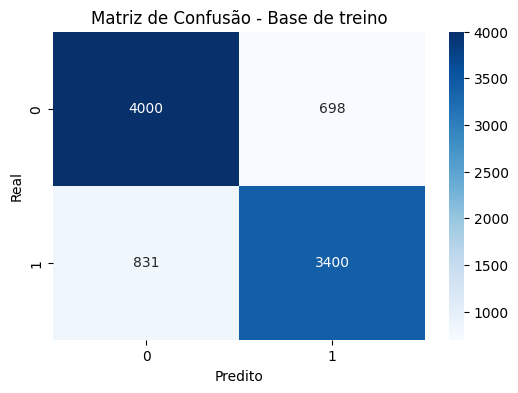

In [98]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Base de treino")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

### Resultados da base de teste

In [99]:
y_pred = model.predict(X_test)

recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

In [100]:
print(f'Recall: {recall*100:.2f}%')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'F1-Score: {f1*100:.2f}%')

Recall: 82.42%
Accuracy: 82.09%
Precision: 80.29%
F1-Score: 81.34%


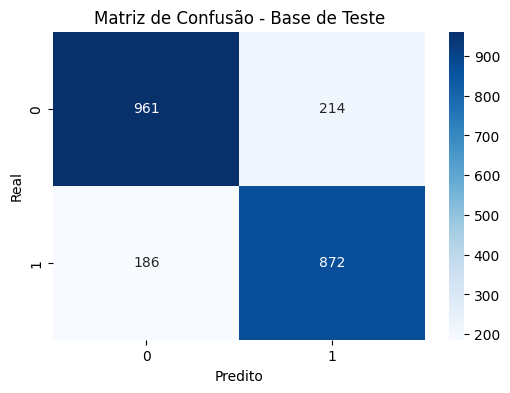

In [101]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Base de Teste")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# Entendendo as variáveis explicativas ( STREAMLIT )

In [102]:
features = X_train.columns

# Coeficientes do modelo
coef = model.coef_[0]


# Se Exp(β) > 1, aumenta a chance.
# Se Exp(β) < 1, diminui a chance.

df_coef = pd.DataFrame({
    'Variável': features,
    'Coeficiente': coef,
    'Exp(β)': np.exp(coef),
    'Abs_Coef': np.abs(coef)
})

df_coef = df_coef.sort_values(by='Abs_Coef', ascending=False)

print(df_coef[['Variável', 'Coeficiente', 'Exp(β)']])


                         Variável  Coeficiente    Exp(β)
37                      month_mar     1.833244  6.254142
6                        duration     1.677290  5.351037
45               poutcome_success     1.649392  5.203816
32                      month_dec     1.283281  3.608460
34                      month_jan    -1.122770  0.325377
39                      month_nov    -0.997058  0.368963
35                      month_jul    -0.986755  0.372785
18                    job_student     0.915055  2.496911
40                      month_oct     0.895464  2.448471
29                contact_unknown    -0.884757  0.412815
41                      month_sep     0.789617  2.202552
31                      month_aug    -0.770003  0.463012
3                         housing    -0.695371  0.498889
38                      month_may    -0.677105  0.508086
27               contact_cellular     0.635549  1.888057
42               poutcome_failure    -0.606122  0.545462
28              contact_telepho

In [103]:
df_coef.head(5)

# Coeficiente positivo → aumenta a probabilidade de resposta positiva.

# Coeficiente negativo → reduz a probabilidade.

# Coeficiente ≈ 0 → pouca ou nenhuma influência.


,Variável,Coeficiente,Exp(β),Abs_Coef
37,month_mar,1.833244,6.254142,1.833244
6,duration,1.677290,5.351037,1.677290
45,poutcome_success,1.649392,5.203816,1.649392
32,month_dec,1.283281,3.608460,1.283281
34,month_jan,-1.122770,0.325377,1.122770


as variáveis que apresentam o coeficiente positivo, aumentam a chance do cliente aceitar a oferta (depositar)

# SGD Classifier

In [104]:
from sklearn.linear_model import SGDClassifier

model_sgd = SGDClassifier(loss='log_loss', max_iter=5000, random_state=42, class_weight='balanced')
model_sgd.fit(X_train, y_train)

y_test_pred = model_sgd.predict(X_test)
y_test_proba = model_sgd.predict_proba(X_test)


### Avaliação Treino


In [105]:
y_train_pred = model_sgd.predict(X_train)
y_train_proba = model_sgd.predict_proba(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
train_logloss = log_loss(y_train, y_train_proba)

recall_train = recall_score(y_train, y_train_pred, average='weighted')
precision_train = precision_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

In [106]:
print(f"Acurácia no treino: {train_acc:.4f}")
print(f"Log Loss no treino: {train_logloss:.4f}")

print(f"Recall: {recall_train:.2%}")
print(f"Precision: {precision_train:.2%}")
print(f"F1-Score: {f1_train:.2%}")

Acurácia no treino: 0.8265
Log Loss no treino: 0.4028
Recall: 82.65%
Precision: 82.69%
F1-Score: 82.62%


### Avaliação Teste


In [107]:
y_test_pred = model_sgd.predict(X_test)
y_test_proba = model_sgd.predict_proba(X_test)

test_acc = accuracy_score(y_test, y_test_pred)
test_logloss = log_loss(y_test, y_test_proba)

recall_test = recall_score(y_test, y_test_pred, average='weighted')
precision_test = precision_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')

In [108]:
print(f"Acurácia no teste: {test_acc:.4f}")
print(f"Log Loss no teste: {test_logloss:.4f}")

print(f"Recall: {recall_test:.2%}")
print(f"Precision: {precision_test:.2%}")
print(f"F1-Score: {f1_test:.2%}")

Acurácia no teste: 0.8168
Log Loss no teste: 0.4315
Recall: 81.68%
Precision: 81.68%
F1-Score: 81.68%



# Comparação de modelos

Concluo que os dois modelos estão muito próximos em perfomance e resultados, o critério de escolha de um ou outro deve ser considerado se for levar em conta o tempo de treino e facilidade de ajuste. Ambos não apresentam overfitting, visto que as métricas de avaliação de treino e teste se aproximam.


In [109]:
joblib.dump(model, 'model_bank.pkl')

['model_bank.pkl']

In [110]:
joblib.dump(scaler, 'scaler_bank.pkl')

['scaler_bank.pkl']